In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, DenseGCNConv
import torch_explain as te
from torch_explain.logic.nn import entropy
from torch_explain.logic.metrics import test_explanation, complexity

import numpy as np
import pandas as pd
from pytorch_lightning.utilities.seed import seed_everything
from scipy.spatial.distance import cdist
from sympy import to_dnf, lambdify
from sklearn.metrics.cluster import homogeneity_score, completeness_score

from sklearn.cluster import KMeans

import clustering_utils
import data_utils
import lens_utils
import model_utils
import persistence_utils
import visualisation_utils

In [3]:
# constants
DATASET_NAME = "Tree_Cycle"
MODEL_NAME = f"GCN for {DATASET_NAME}"
NUM_CLASSES = 2
K = 10

TRAIN_TEST_SPLIT = 0.8

NUM_HIDDEN_UNITS = 10
EPOCHS = 7000
LR = 0.001

NUM_NODES_VIEW = 5
NUM_EXPANSIONS = 4

LAYER_NUM = 2
LAYER_KEY = "conv2"

visualisation_utils.set_rc_params()

In [4]:
# model definition
class GCN(nn.Module):
    def __init__(self, num_in_features, num_hidden_features, num_classes):
        super(GCN, self).__init__()
        
        self.conv0 = DenseGCNConv(num_in_features, num_hidden_features)
        self.conv1 = DenseGCNConv(num_hidden_features, num_hidden_features)
        self.conv2 = DenseGCNConv(num_hidden_features, num_hidden_features)
                
        # linear layers
        self.linear = nn.Linear(num_hidden_features, num_classes)

    def forward(self, x, edge_index):
        x = self.conv0(x, edge_index)
        x = F.leaky_relu(x)

        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)

        x = self.conv2(x, edge_index)
        x = F.leaky_relu(x)
        
        x = x.squeeze()
        
        x = self.linear(x)
                
        return F.log_softmax(x, dim=-1)

In [5]:
def run_experiment(seed, path, load_pretrained=False):
    persistence_utils.save_config(seed, DATASET_NAME, MODEL_NAME, NUM_CLASSES, K, TRAIN_TEST_SPLIT, NUM_HIDDEN_UNITS, EPOCHS, LR, NUM_NODES_VIEW, NUM_EXPANSIONS, LAYER_NUM, LAYER_KEY, path)
        
    # load data
    G, labels = data_utils.load_syn_data(DATASET_NAME)
    data = data_utils.prepare_syn_data(G, labels, TRAIN_TEST_SPLIT)


    x = data["x"]
    edges = data['edges']
    edges_t = data['edge_list'].numpy()
    y = data["y"]
    train_mask = data["train_mask"]
    test_mask = data["test_mask"]

    # model training
    model = GCN(data["x"].shape[1], NUM_HIDDEN_UNITS, NUM_CLASSES)
    
    if load_pretrained:
        model = persistence_utils.load_model(model, path, 'model.z')
        model_utils.activation_list = persistence_utils.load_experiment(path, 'activation_list.z')
        
    else:
        # register hooks to track activation
        model = model_utils.register_hooks(model)

        # train 
        train_acc, test_acc, train_loss, test_loss = model_utils.train(model, data, EPOCHS, LR, if_interpretable_model=False)
        persistence_utils.persist_model(model, path, 'model.z')
        
        visualisation_utils.plot_model_accuracy(train_acc, test_acc, MODEL_NAME, path)
        visualisation_utils.plot_model_loss(train_loss, test_loss, MODEL_NAME, path)
        
        # get model activations for complete dataset
        pred = model(x, edges)
        persistence_utils.persist_experiment(model_utils.activation_list, path, 'activation_list.z')
        
    activation = torch.squeeze(model_utils.activation_list[LAYER_KEY]).detach().numpy()

    # find centroids
    kmeans_model = KMeans(n_clusters=K, random_state=seed)
    kmeans_model = kmeans_model.fit(activation[train_mask])
    used_centroid_labels = kmeans_model.predict(activation)
    centroid_labels = np.sort(np.unique(used_centroid_labels))
    centroids = kmeans_model.cluster_centers_
    
    persistence_utils.persist_experiment(kmeans_model, path, 'kmeans_model.z')
    persistence_utils.persist_experiment(centroids, path, 'centroids.z')
    persistence_utils.persist_experiment(centroid_labels, path, 'centroid_labels.z')
    persistence_utils.persist_experiment(used_centroid_labels, path, 'used_centroid_labels.z')
        
    print(f"Number of cenroids: {len(centroids)}")
    
    # plot concept heatmaps
    visualisation_utils.plot_concept_heatmap(centroids, used_centroid_labels, y, used_centroid_labels, MODEL_NAME, LAYER_NUM, path)
    
    # concept alignment
    homogeneity = homogeneity_score(y, used_centroid_labels)
    
    # clustering efficency
    completeness = completeness_score(y, used_centroid_labels)
    
    # calculate cluster sizing
    cluster_counts = visualisation_utils.print_cluster_counts(used_centroid_labels)
    
    concept_metrics = [('homogeneity', homogeneity), ('completeness', completeness), ('cluster_count', cluster_counts)]
    persistence_utils.persist_experiment(concept_metrics, path, 'concept_metrics.z')

    print(f"Concept homogeneity score: {homogeneity}")
    print(f"Concept completeness score: {completeness}")

    # plot clustering
    visualisation_utils.plot_clustering(seed, activation, y, centroids, centroid_labels, used_centroid_labels, MODEL_NAME, LAYER_NUM, path)

    # plot samples
    sample_graphs, sample_feat = visualisation_utils.plot_samples(kmeans_model, activation, y, LAYER_NUM, len(centroids), "Differential Clustering", "Raw", NUM_NODES_VIEW, edges_t, NUM_EXPANSIONS, path)
    persistence_utils.persist_experiment(sample_graphs, path, 'sample_graphs.z')
    persistence_utils.persist_experiment(sample_feat, path, 'sample_feat.z')
    
    # clean up
    plt.close()

Global seed set to 42



START EXPERIMENT-----------------------------------------

Task: Node Classification
Number of features:  871
Number of labels:  871
Number of classes:  871
Number of edges:  2
Number of cenroids: 10
Cluster sizes by cluster id:
	Cluster 0: 169
	Cluster 1: 224
	Cluster 2: 68
	Cluster 3: 42
	Cluster 4: 72
	Cluster 5: 106
	Cluster 6: 15
	Cluster 7: 80
	Cluster 8: 62
	Cluster 9: 33
Concept homogeneity score: 0.6880484897025244
Concept completeness score: 0.2246744963883348


/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword a

<Figure size 864x576 with 0 Axes>

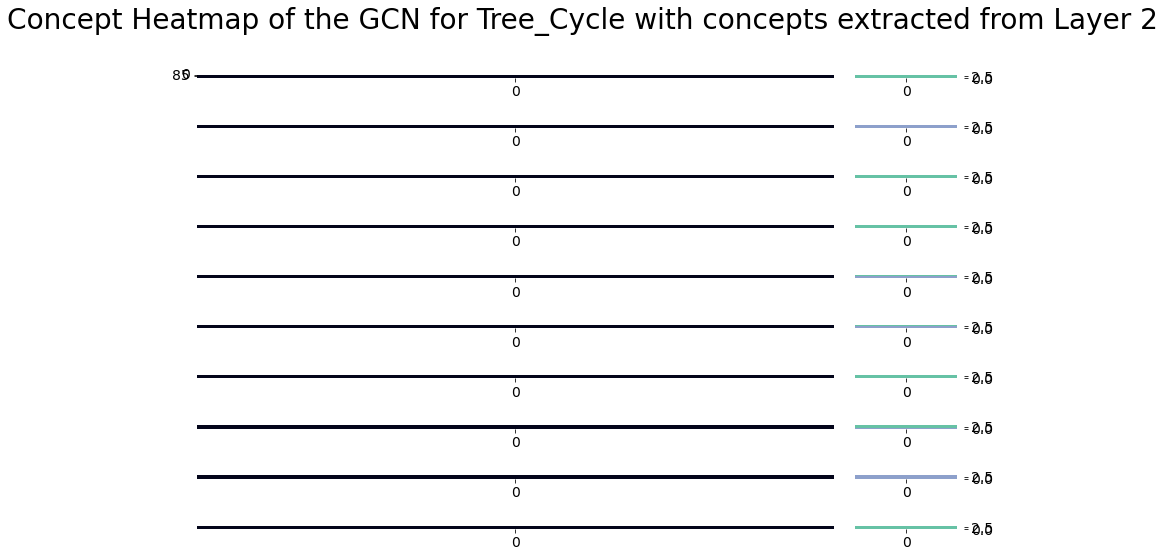

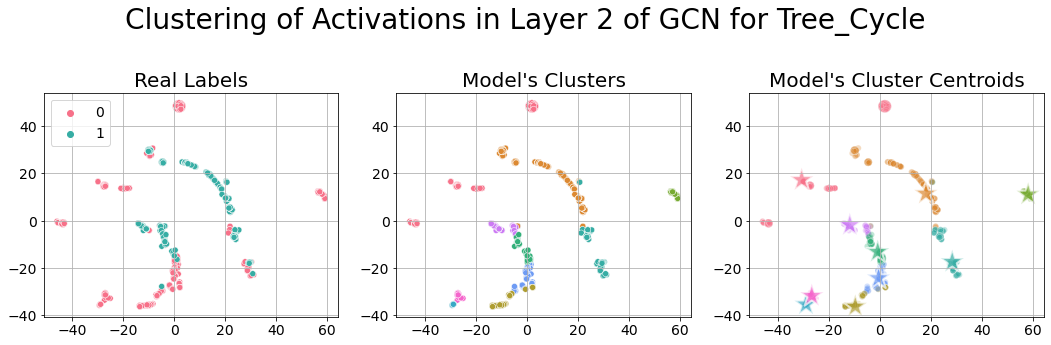

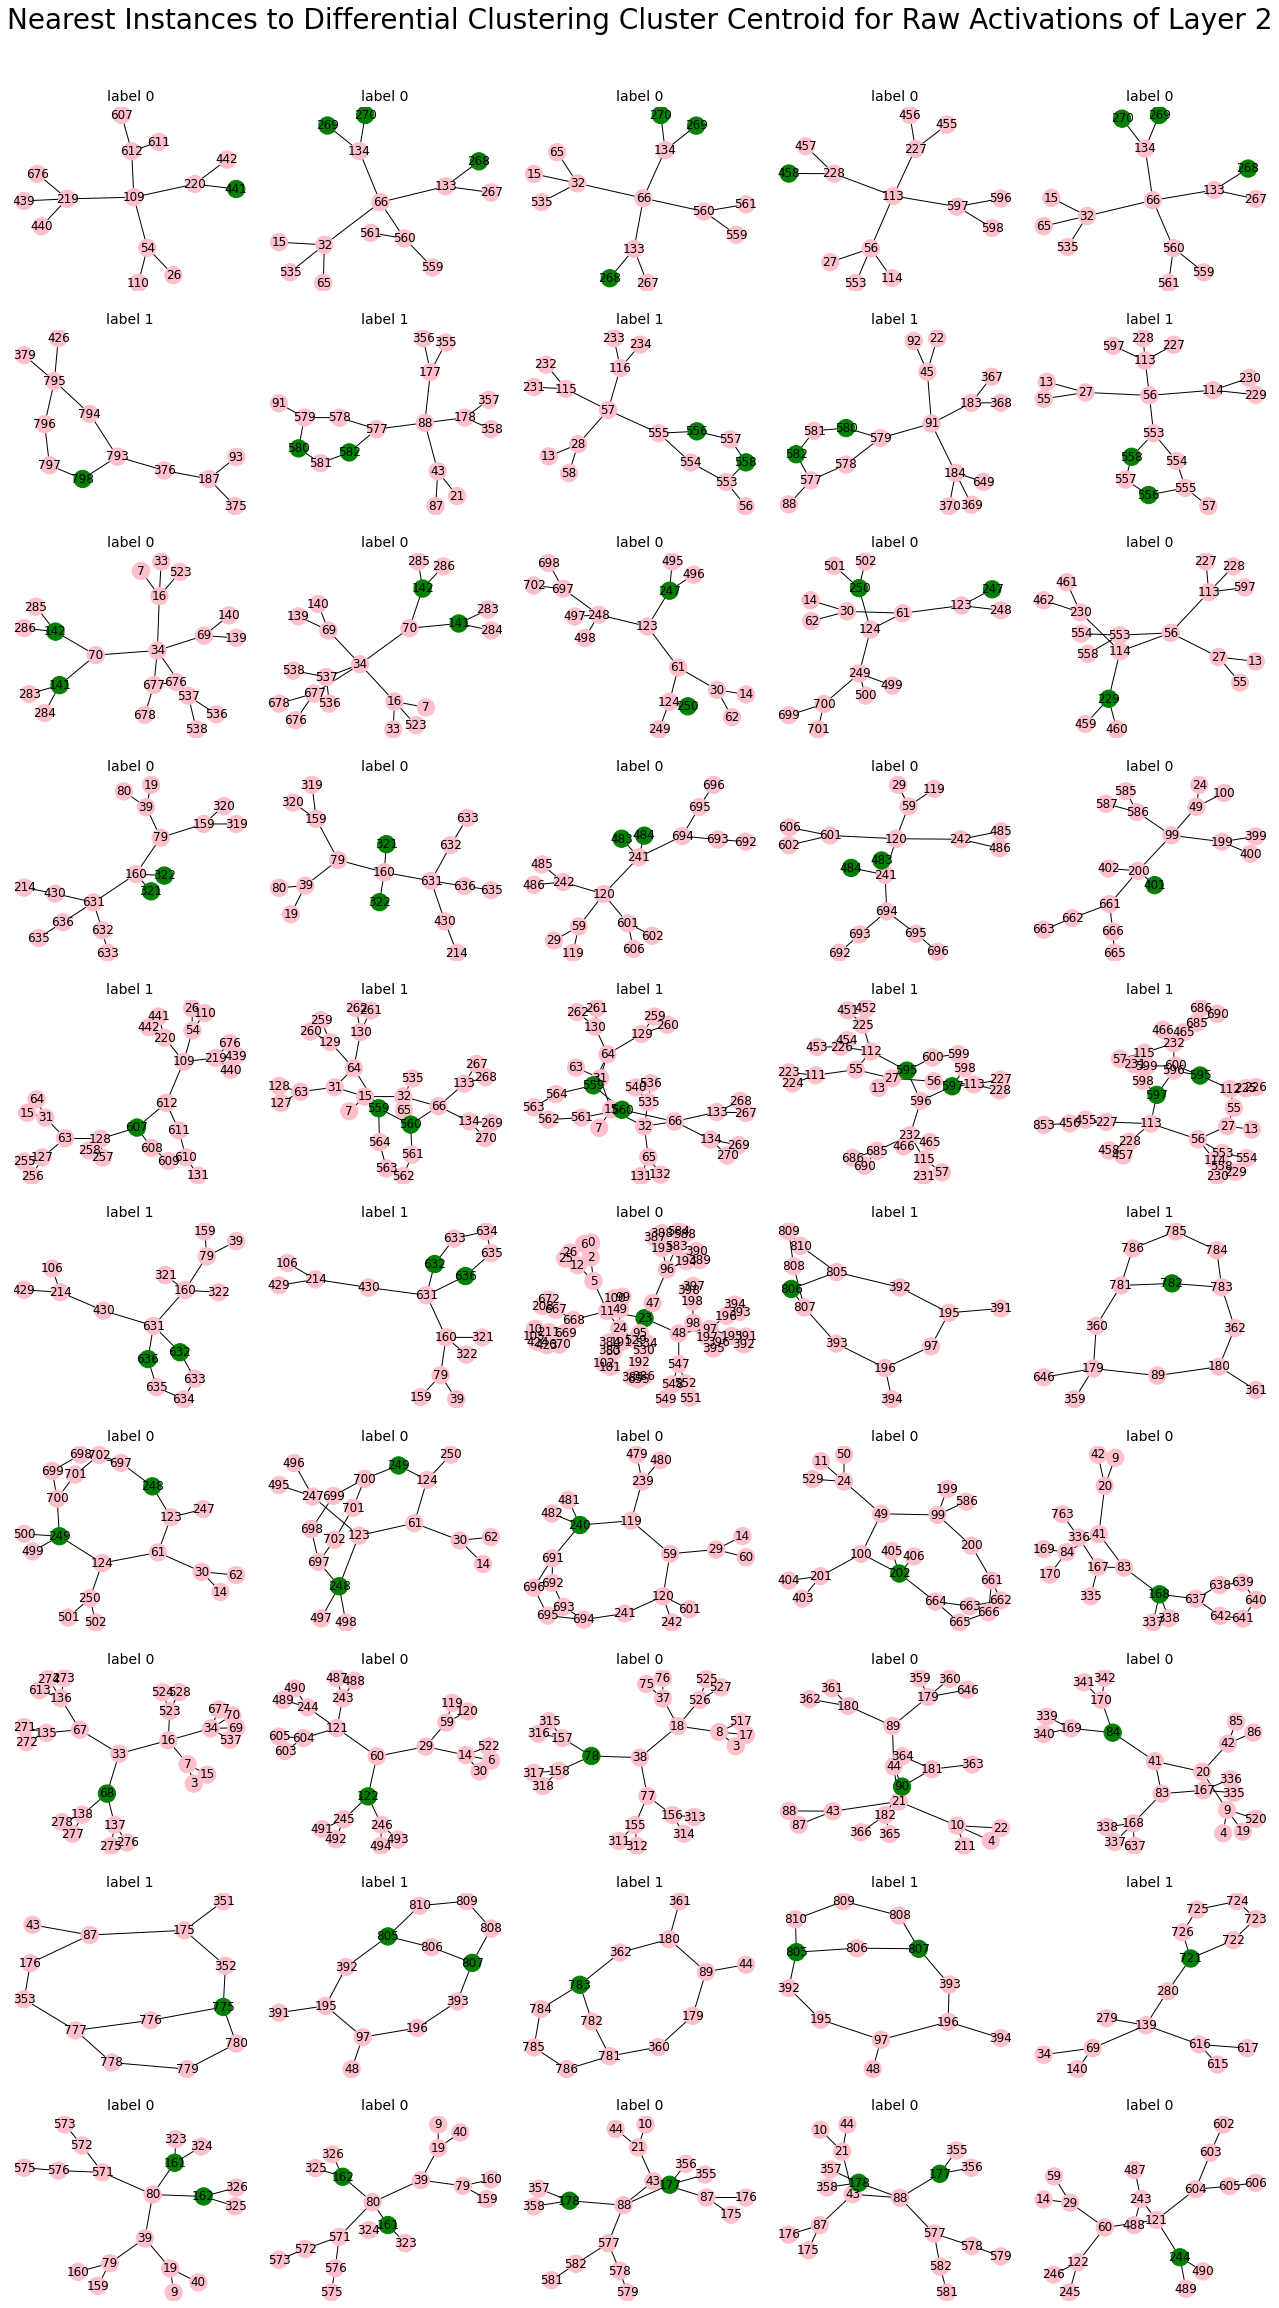

Global seed set to 19



END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

Task: Node Classification
Number of features:  871
Number of labels:  871
Number of classes:  871
Number of edges:  2
Number of cenroids: 10
Cluster sizes by cluster id:
	Cluster 0: 276
	Cluster 1: 139
	Cluster 2: 36
	Cluster 3: 78
	Cluster 4: 105
	Cluster 5: 55
	Cluster 6: 31
	Cluster 7: 94
	Cluster 8: 42
	Cluster 9: 15
Concept homogeneity score: 0.6491597588690879
Concept completeness score: 0.21904686028104056


/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword a

<Figure size 864x576 with 0 Axes>

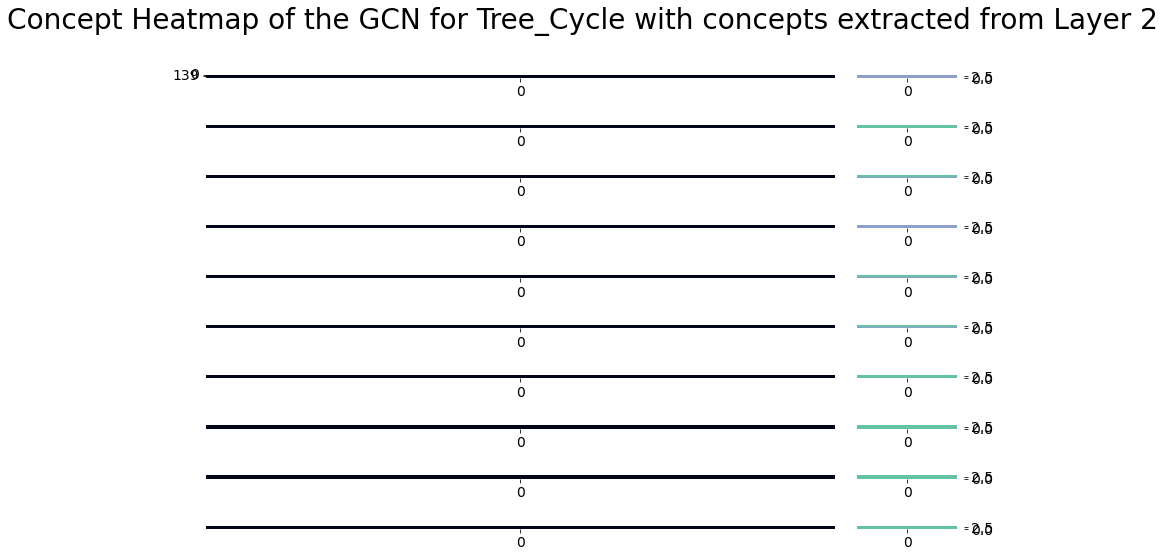

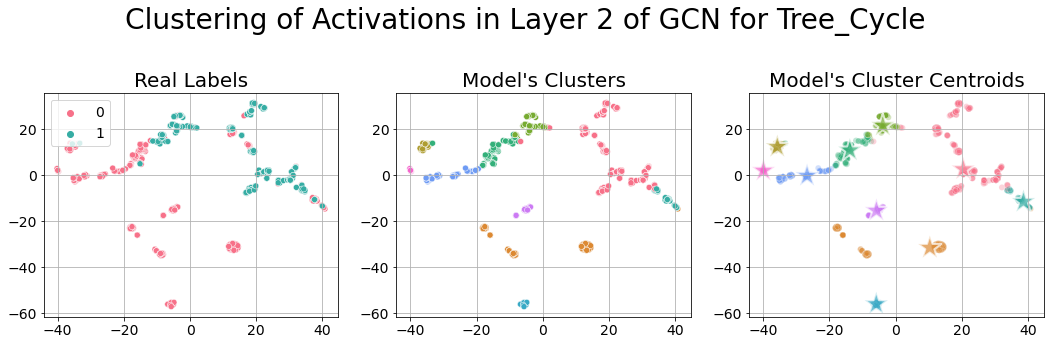

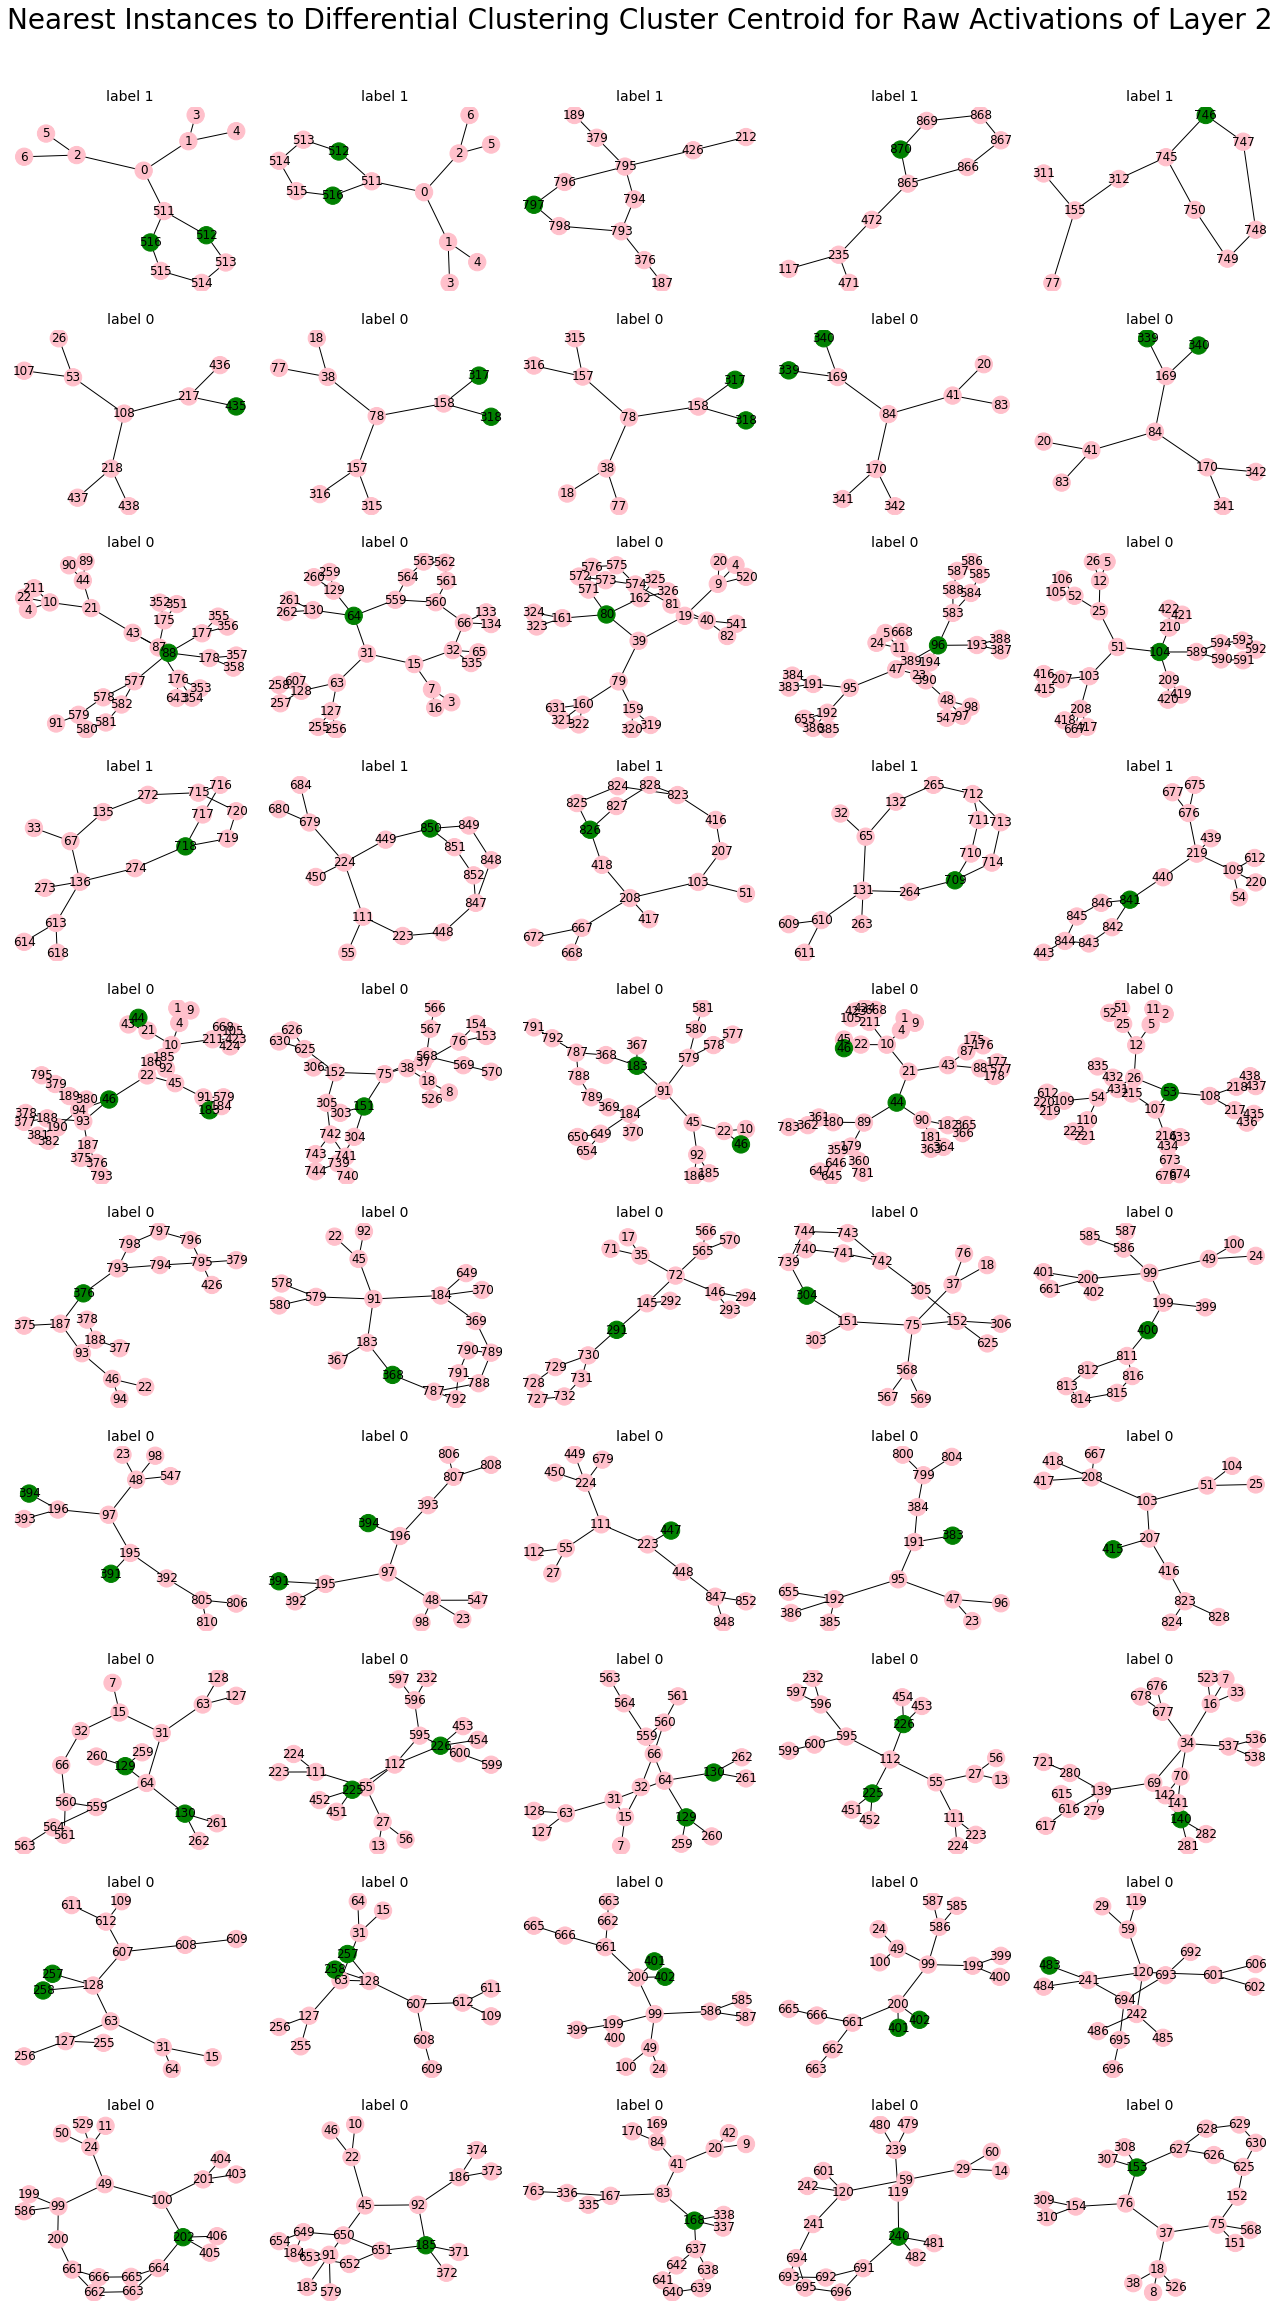

Global seed set to 76



END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

Task: Node Classification
Number of features:  871
Number of labels:  871
Number of classes:  871
Number of edges:  2
Number of cenroids: 10
Cluster sizes by cluster id:
	Cluster 0: 66
	Cluster 1: 211
	Cluster 2: 161
	Cluster 3: 74
	Cluster 4: 131
	Cluster 5: 50
	Cluster 6: 25
	Cluster 7: 73
	Cluster 8: 58
	Cluster 9: 22
Concept homogeneity score: 0.5833625603226011
Concept completeness score: 0.18903115118261268


/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword a

<Figure size 864x576 with 0 Axes>

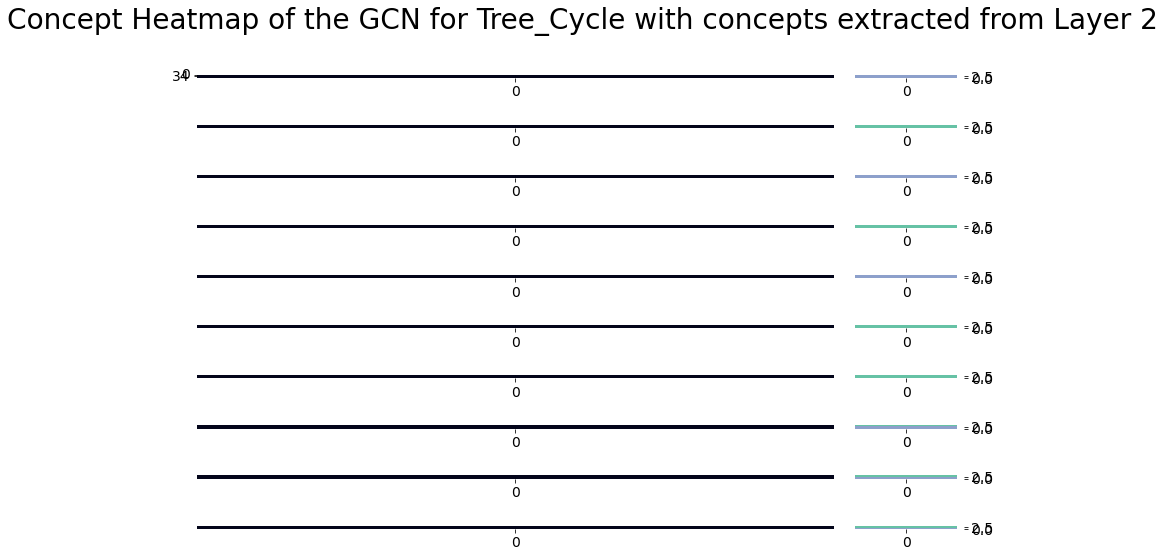

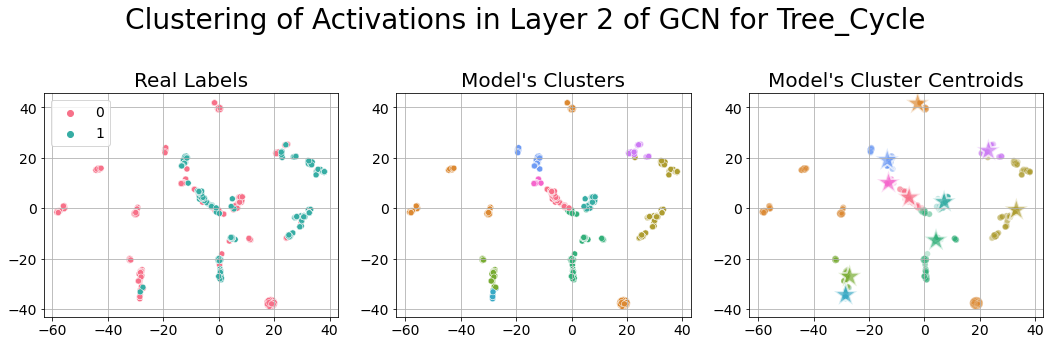

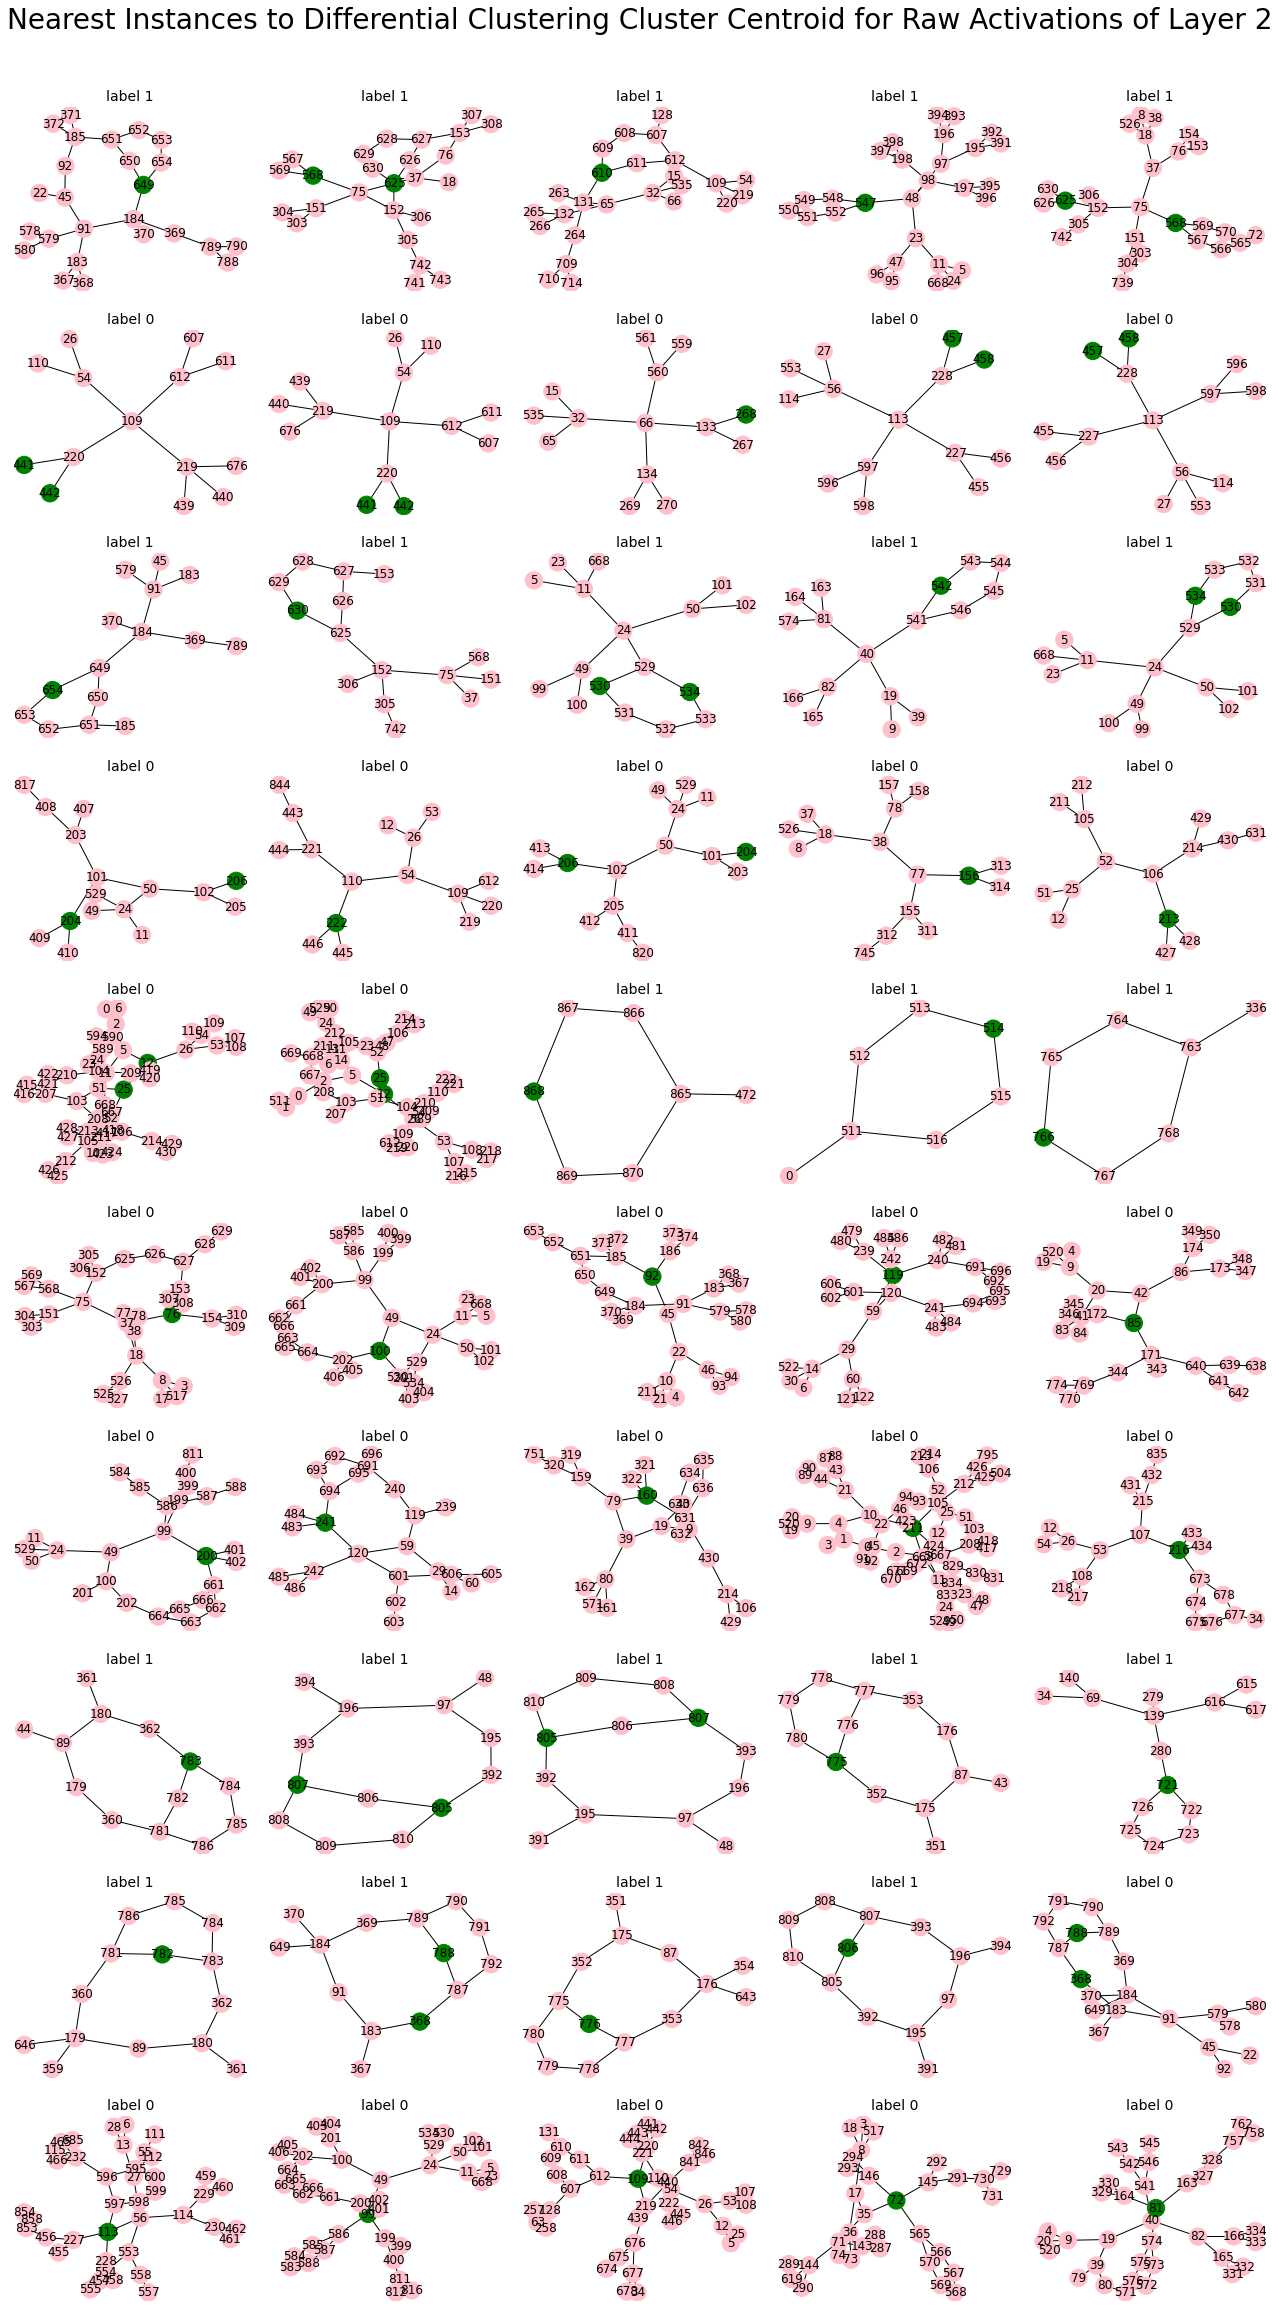

Global seed set to 58



END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

Task: Node Classification
Number of features:  871
Number of labels:  871
Number of classes:  871
Number of edges:  2
Number of cenroids: 10
Cluster sizes by cluster id:
	Cluster 0: 138
	Cluster 1: 74
	Cluster 2: 143
	Cluster 3: 90
	Cluster 4: 91
	Cluster 5: 53
	Cluster 6: 73
	Cluster 7: 30
	Cluster 8: 138
	Cluster 9: 41
Concept homogeneity score: 0.7146808356952038
Concept completeness score: 0.22042034793590998


/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword a

<Figure size 864x576 with 0 Axes>

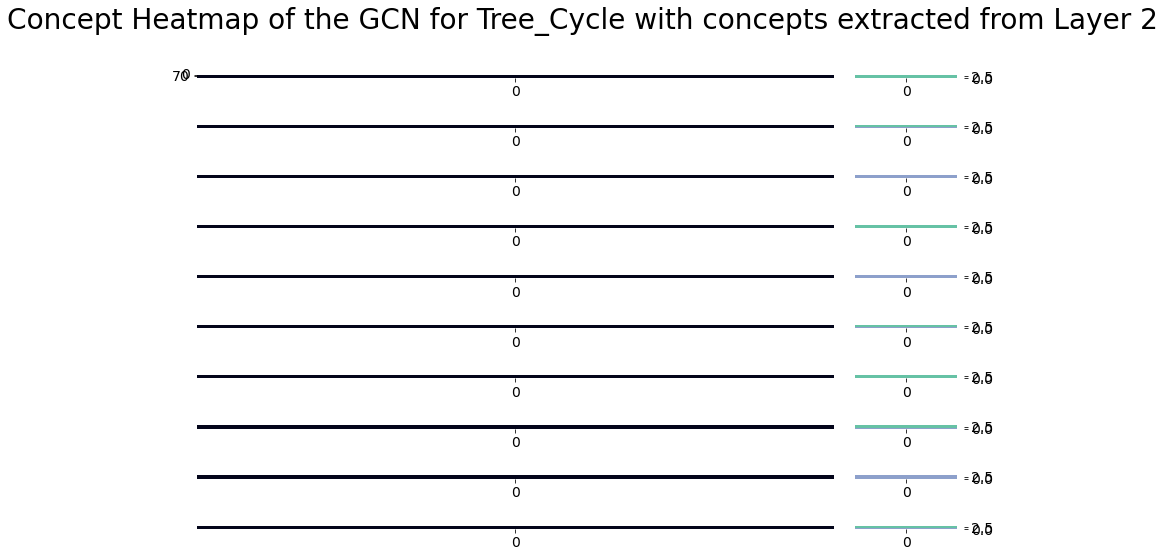

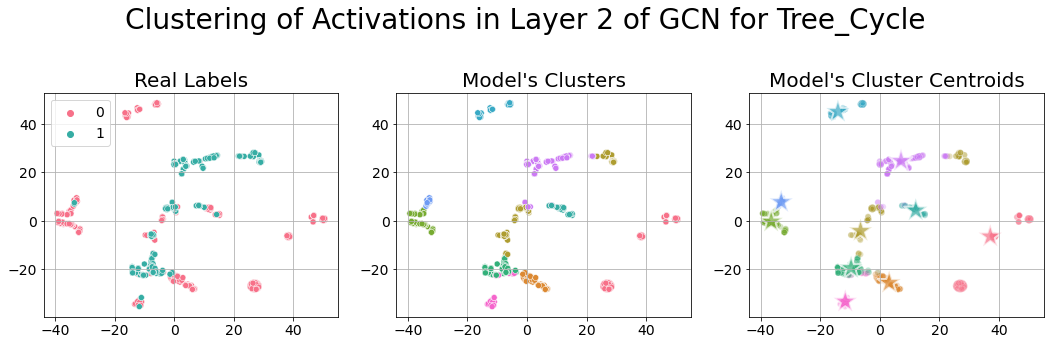

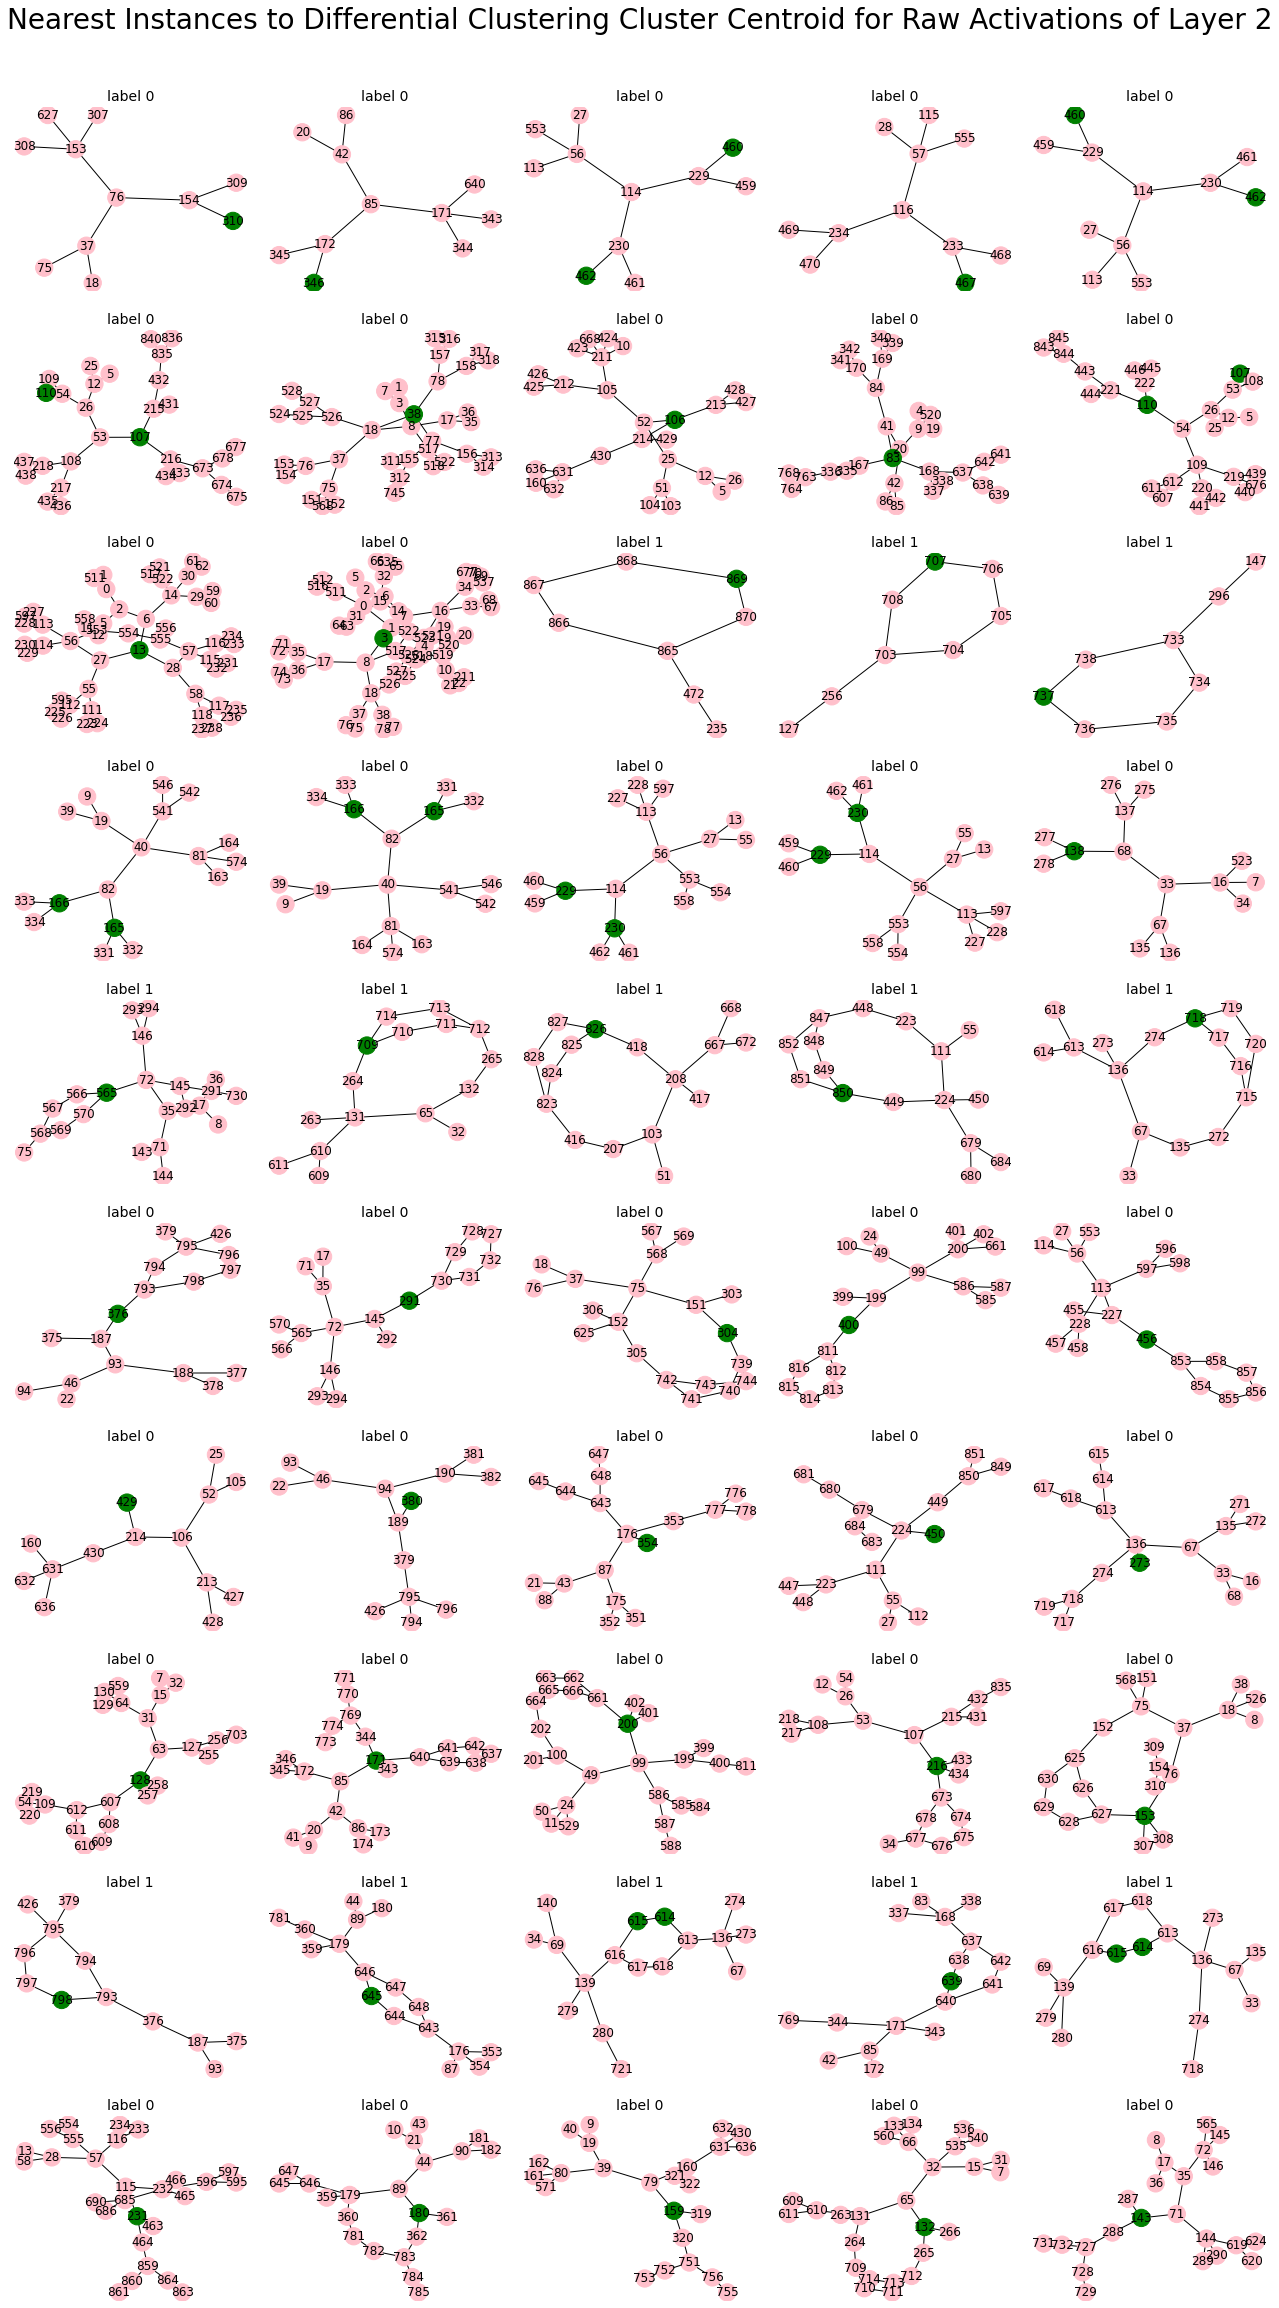

Global seed set to 92



END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

Task: Node Classification
Number of features:  871
Number of labels:  871
Number of classes:  871
Number of edges:  2
Number of cenroids: 10
Cluster sizes by cluster id:
	Cluster 0: 113
	Cluster 1: 142
	Cluster 2: 78
	Cluster 3: 170
	Cluster 4: 46
	Cluster 5: 42
	Cluster 6: 64
	Cluster 7: 132
	Cluster 8: 67
	Cluster 9: 17
Concept homogeneity score: 0.7329129242381547
Concept completeness score: 0.23123685645611403


/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword a

<Figure size 864x576 with 0 Axes>

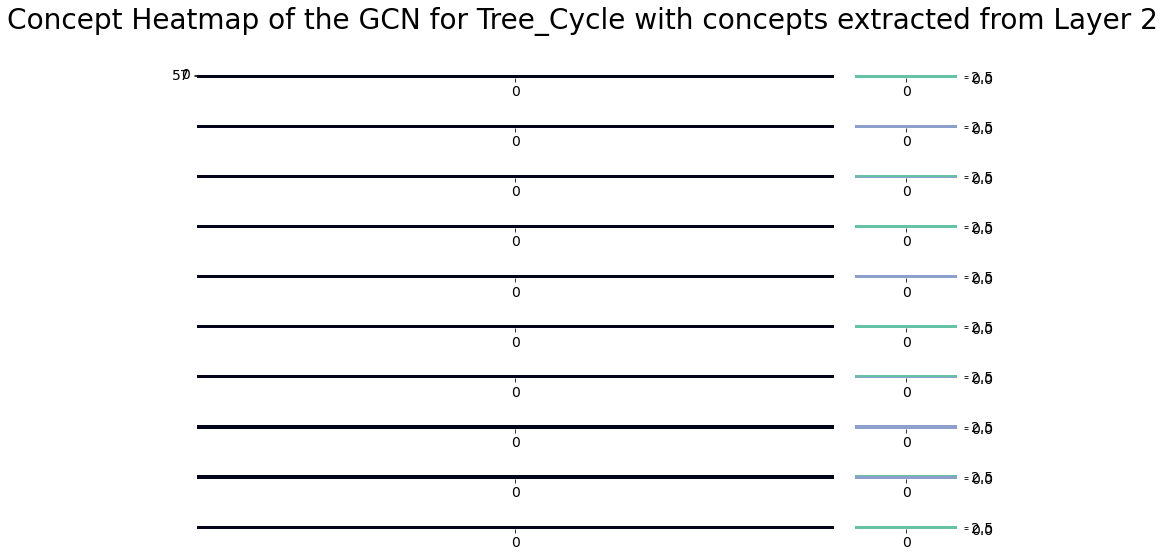

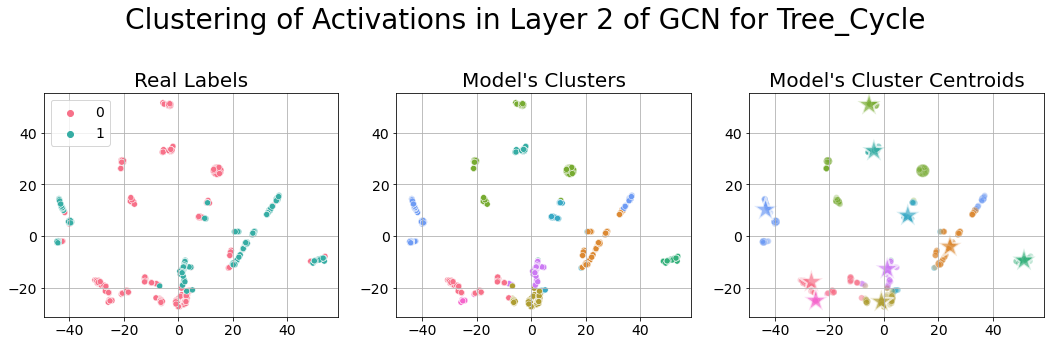

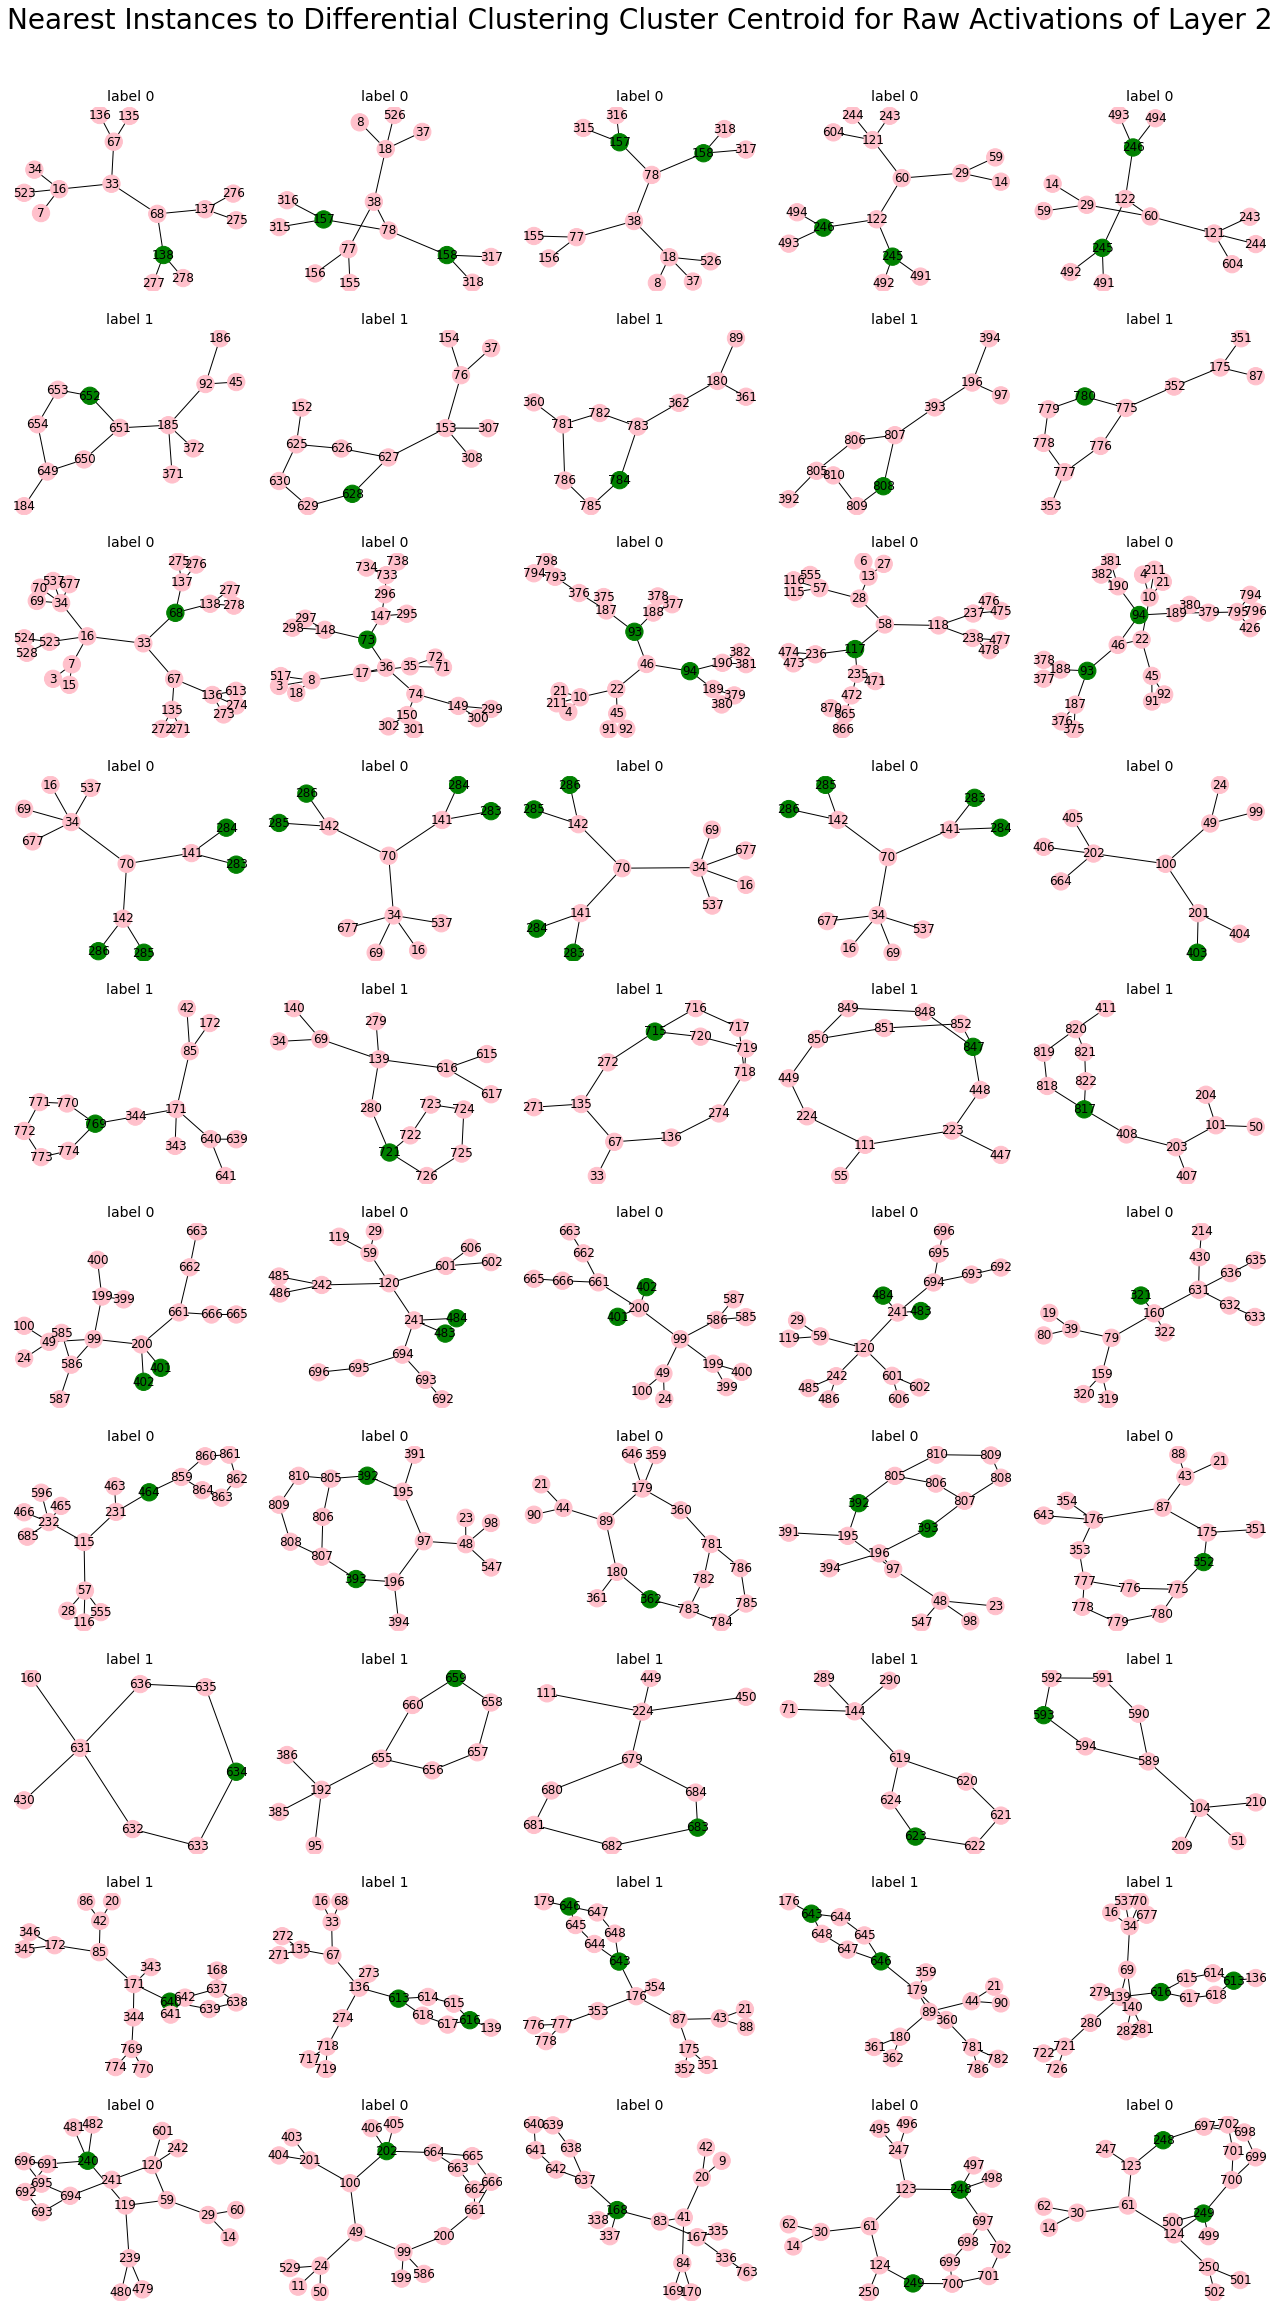


END EXPERIMENT-------------------------------------------



In [6]:
# run multiple times for confidence interval - seeds generated using Google's random number generator
random_seeds = [42, 19, 76, 58, 92]

for seed in random_seeds:
    print("\nSTART EXPERIMENT-----------------------------------------\n")
    seed_everything(seed)
    
    path = os.path.join("..", "output", "Standard_" + DATASET_NAME, f"seed_{seed}")
    data_utils.create_path(path)

    run_experiment(seed, path, load_pretrained=True)
    
    print("\nEND EXPERIMENT-------------------------------------------\n")